# **딥러닝-회귀**


## **1.환경준비**

### (1) 라이브러리 Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [ ]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 연결

        # Feed Forward
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [ ]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [ ]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [ ]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

### (4) 데이터로딩

In [ ]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv'
data = pd.read_csv(path)
data.head()

|	변수	|	설명	|
|	----	|	----	|
|	medv	|	타운별 집값(중위수)	|
|	crim	|	범죄율	|
|	zn	|	25,000 평방피트를 초과 거주지역 비율	|
|	indus	|	비소매상업지역 면적 비율	|
|	chas	|	찰스강변 위치(범주 : 강변1, 아니면 0)	|
|	nox	|	일산화질소 농도	|
|	rm	|	주택당 방 수	|
|	age	|	1940년 이전에 건축된 주택의 비율	|
|	dis	|	직업센터의 거리	|
|	rad	|	방사형 고속도로까지의 거리	|
|	tax	|	재산세율	|
|	ptratio	|	학생/교사 비율	|
|	lstat	|	인구 중 하위 계층 비율	|


## **2.데이터 준비**

lstat, ptratio, crim 만 이용하여 medv를 예측하는 모델을 만들어 봅시다.

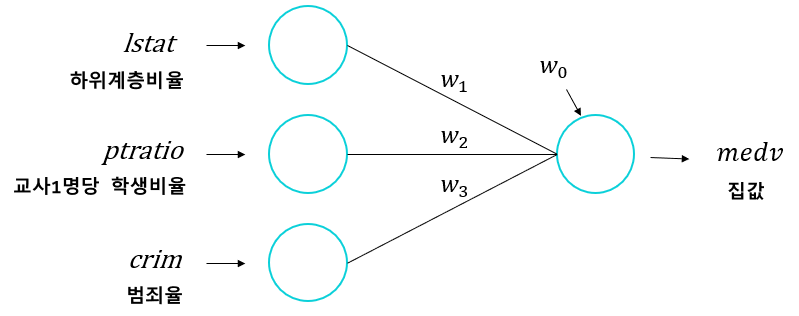

### (1) 데이터 준비
* x, y 나누기
    * x : lstat, ptratio, crim
    * y : medv

In [ ]:
target = 'medv'
features = ['lstat', 'ptratio', 'crim']
x = data.loc[:, features]
y = data.loc[:, target]

### (2) 가변수화

### (3) 데이터분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

### (4) Scaling

In [ ]:
# 스케일러 선언
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## **3.모델링1 : feature 3개**

### (1) 딥러닝을 위한 준비작업

* make_DataLoader
    * train : 미니 배치 처리를 위한 데이터 로더로 만들기
    * val : 검증셋으로 성능 측정하면 되므로 텐서 그대로 사용

In [ ]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [ ]:
# 첫번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f"Shape of x [rows, columns]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

### (2) 모델 선언

* nn.Linear(입력, 출력) 레이어 한개를 추가해 봅시다.
    * [출력] 층의 **노드 수** 입니다.

In [ ]:
n_feature = x.shape[1]

# 모델 구조 설계
model1 = nn.Sequential(

        ).to(device)

print(model1)

* Loss function과 Optimizer
    * loss function : MSE
    * Optimizer : Adam(모델 파라미터, 학습률)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = Adam(model1.parameters(), lr=0.1)

### (3) 학습

In [ ]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model1, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

* 학습된 파라미터 확인

In [ ]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

* 학습 곡선

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [ ]:
loss, pred = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)
print(f'MSE : {loss}')

* 평가 추가 : MAE, MAPE
    * sklearn 평가지표는 토치 텐서 지원 안함
    * 그러므로, 넘파이로 변환하고 입력해야 함.

In [ ]:
mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())
print(f'MAE : {mae}')
print(f'MAPE : {mape}')

## **4.모델링2 : feature 전체**
* 이제 전체 데이터를 가지고 모델링을 시도해 보겠습니다.


### (1) 데이터 전처리

* 데이터 분할

In [ ]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:, target]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

* 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 모델링

* make_DataLoader

In [ ]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val)

* 모델 설계

In [ ]:
n_feature = x.shape[1]

# 모델 구조 설계
model2 = nn.Sequential(

                       ).to(device)

print(model2)

* Loss function과 Optimizer

In [ ]:
loss_fn =
optimizer =

### (3) 학습

In [ ]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss =
    val_loss, _ =

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

* 학습된 파라미터 확인

In [ ]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

* 학습 곡선

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [ ]:
loss, pred = evaluate(x_val_ts, y_val_ts, model2, loss_fn, device)

mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())

print(f'MSE : {loss}')
print(f'MAE : {mae}')
print(f'MAPE : {mape}')

## **5.모델링3 : 은닉층 추가**

### (1) 데이터 전처리
4.모델링2 에서 준비한 데이터를 이용합니다.

### (2) 모델링
4.모델링2 에서 선언한 DataLoader를 그대로 사용합니다.

* 모델 설계

In [ ]:
n_feature = x.shape[1]

# 모델 구조 설계
model3 = nn.Sequential(
            nn.Linear(n_feature, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
        ).to(device)

print(model3)

* Loss function과 Optimizer

In [ ]:
loss_fn =
optimizer =

### (3) 학습

In [ ]:
epochs = 100
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss =
    val_loss, _ =

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

* 학습된 파라미터 확인

In [ ]:
for name, param in model3.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

* 학습 곡선

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [ ]:
loss, pred =

mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())

print(f'MSE : {loss}')
print(f'MAE : {mae}')
print(f'MAPE : {mape}')

## **6.실습1**
* 여러분은 다음의 구조대로 모델링을 수행하고 성능평가를 해 봅시다.
    * 모델 구조
            Sequential(
              (0): Linear(in_features=12, out_features=10, bias=True)
              (1): ReLU()
              (2): Linear(in_features=10, out_features=5, bias=True)
              (3): ReLU()
              (4): Linear(in_features=5, out_features=1, bias=True)
            )
    * epochs(반복횟수) : 100
    * lr(learning rate, 학습률) : 0.01

* 모델 설계

* Loss function과 Optimizer

* 학습

* 학습 곡선

* 모델 평가 : MSE

## **7.실습2**
* 이번에는 여러분이 원하는 구조와 하이퍼파라미터 값을 조정하여 성능을 높여 봅시다.

* 모델 설계

* Loss function과 Optimizer

* 학습

* 학습 곡선

* 모델 평가 : MSE